# Define Libraries

In [16]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Data Preparation and Loading

In [15]:
train_dir = "new_tr"  
val_dir = "new_val"  
test_dir = "new_test"  

img_size = (32, 32)  
batch_size = 140

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
test_data = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')

Found 5096 images belonging to 2 classes.
Found 136 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building CNN Model

In [17]:
def build_cnn_model():
    model = Sequential([
        Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        14,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,545 (56.82 KB)

 Trainable params: 14,545 (56.82 KB)

 Non-trainable params: 0 (0.00 B)

# Trainig CNN  Model  

In [18]:
history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data),
    verbose=1
)

test_loss, test_accuracy = cnn_model.evaluate(test_data)
print(f"Test Accuracy without enhancements: {test_accuracy:.2f}")


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6897 - loss: 0.6103 - val_accuracy: 0.5000 - val_loss: 0.8102
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.7387 - loss: 0.5311 - val_accuracy: 0.5000 - val_loss: 0.7083
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.7684 - loss: 0.4445 - val_accuracy: 0.6103 - val_loss: 0.5984
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8476 - loss: 0.3481 - val_accuracy: 0.7279 - val_loss: 0.4782
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8925 - loss: 0.2846 - val_accuracy: 0.7353 - val_loss: 0.4837
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9081 - loss: 0.2417 - val_accuracy: 0.7574 - val_loss: 0.4339
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9240 - loss: 0.2077 - val_accuracy: 0.7647 - val_loss: 0.4493
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9232 - loss: 0.1925 - val_accuracy: 0.7941 - val_loss

# PreProcessing And Enhancement Images 

In [6]:
def enhance_image(img):
    gamma = 1.5
    gamma_correction = np.array(255 * (img / 255) ** (1 / gamma), dtype='uint8')

    lab = cv2.cvtColor(gamma_correction, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16, 16))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    enhanced_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    enhanced_img = cv2.GaussianBlur(enhanced_img, (5, 5), sigmaX=1.5, sigmaY=1.5)
    enhanced_img = cv2.medianBlur(enhanced_img, 5)

    blurred = cv2.GaussianBlur(enhanced_img, (9, 9), 10.0)
    enhanced_img = cv2.addWeighted(enhanced_img, 1.5, blurred, -0.5, 0)

    result = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2LAB)
    avg_a = np.mean(result[:, :, 1])
    avg_b = np.mean(result[:, :, 2])

    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * 0.5)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * 0.5)
    result[:, :, 1] = np.clip(result[:, :, 1], 0, 255)
    result[:, :, 2] = np.clip(result[:, :, 2], 0, 255)

    enhanced_img = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

    return enhanced_img


def enhance_images_in_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                enhanced_img = enhance_image(img)

                relative_path = os.path.relpath(root, input_dir)
                save_dir = os.path.join(output_dir, relative_path)
                os.makedirs(save_dir, exist_ok=True)
                cv2.imwrite(os.path.join(save_dir, file), cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR))

train_enhanced_dir = "enhanced_tr"
val_enhanced_dir = "enhanced_vald"
test_enhanced_dir = "enhanced_tst"

enhance_images_in_directory(train_dir, train_enhanced_dir)
enhance_images_in_directory(val_dir, val_enhanced_dir)
enhance_images_in_directory(test_dir, test_enhanced_dir)

enhanced_train_data = train_datagen.flow_from_directory(
    train_enhanced_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
enhanced_val_data = val_datagen.flow_from_directory(
    val_enhanced_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')
enhanced_test_data = test_datagen.flow_from_directory(
    test_enhanced_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')


Found 5096 images belonging to 2 classes.
Found 136 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [28]:
def cnn_model_2():
    model = Sequential([
        Conv2D(4, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = cnn_model_2()
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 4)      │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │        14,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,545 (56.82 KB)

 Trainable params: 14,545 (56.82 KB)

 Non-trainable params: 0 (0.00 B)

# Training CNN Model After Enhancment (images)

In [25]:
history_enhanced = cnn_model.fit(
    enhanced_train_data,
    validation_data=enhanced_val_data,
    epochs=10,
    steps_per_epoch=len(enhanced_train_data),
    validation_steps=len(enhanced_val_data)
)

test_loss_enhanced, test_accuracy_enhanced = cnn_model.evaluate(enhanced_test_data)
print(f"Test Accuracy with enhancements: {test_accuracy_enhanced:.2f}")


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.7517 - loss: 0.5466 - val_accuracy: 0.5000 - val_loss: 0.6712
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.7807 - loss: 0.4355 - val_accuracy: 0.5074 - val_loss: 0.6885
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.8489 - loss: 0.3390 - val_accuracy: 0.8088 - val_loss: 0.4205
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9047 - loss: 0.2701 - val_accuracy: 0.8676 - val_loss: 0.3371
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9201 - loss: 0.2249 - val_accuracy: 0.8824 - val_loss: 0.2928
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.9320 - loss: 0.1945 - val_accuracy: 0.8750 - val_loss: 0.2998
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9386 - loss: 0.1709 - val_accuracy: 0.8750 - val_loss: 0.3172
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.9392 - loss: 0.1627 - val_accuracy: 0.8824 - v

# Show Result Before && After Enhancement 

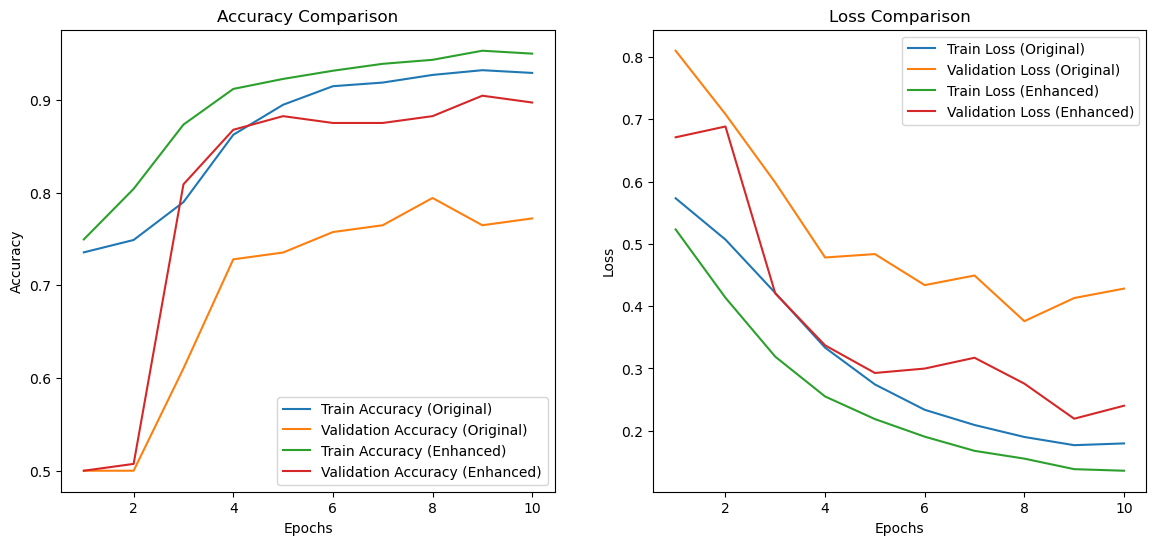

In [26]:
def plot_results(history, history_enhanced):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy (Original)')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy (Original)')
    plt.plot(epochs, history_enhanced.history['accuracy'], label='Train Accuracy (Enhanced)')
    plt.plot(epochs, history_enhanced.history['val_accuracy'], label='Validation Accuracy (Enhanced)')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss (Original)')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss (Original)')
    plt.plot(epochs, history_enhanced.history['loss'], label='Train Loss (Enhanced)')
    plt.plot(epochs, history_enhanced.history['val_loss'], label='Validation Loss (Enhanced)')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_results(history, history_enhanced)


# Show Images Before And After Preprocessing 

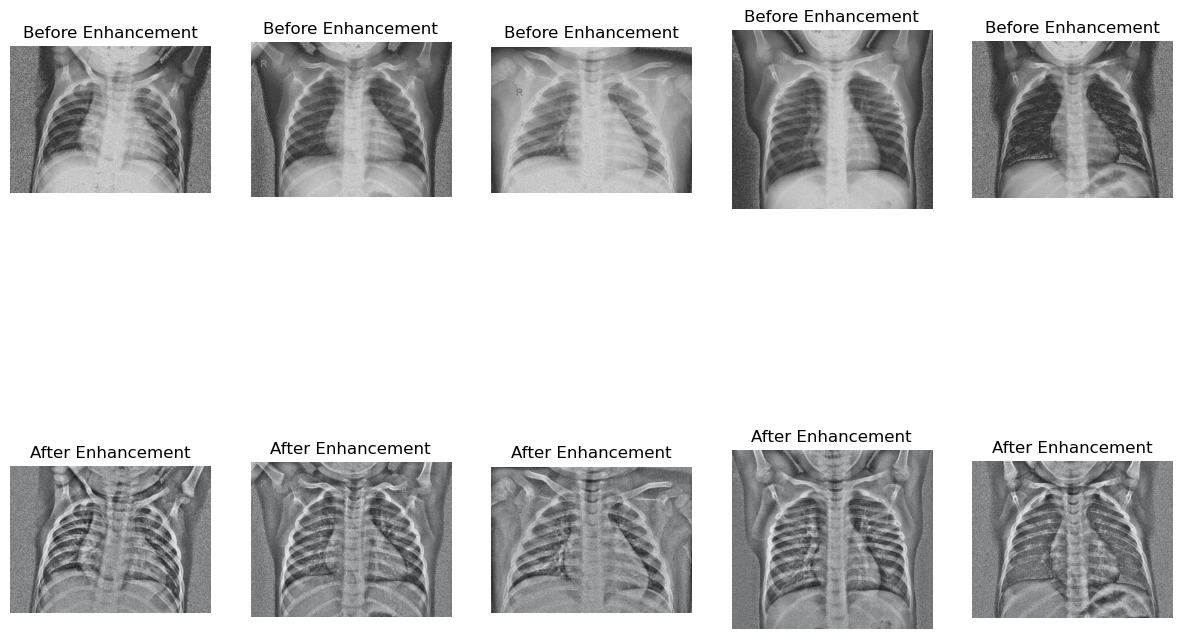

In [27]:
def display_sample_images(input_dir, output_dir, sample_count=5):
    input_images = []
    output_images = []

    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')) and len(input_images) < sample_count:
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                input_images.append(img)

                enhanced_img_path = os.path.join(output_dir, os.path.relpath(img_path, input_dir))
                if os.path.exists(enhanced_img_path):
                    enhanced_img = cv2.imread(enhanced_img_path)
                    enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)
                    output_images.append(enhanced_img)

    plt.figure(figsize=(15, 10))
    for i in range(sample_count):
        plt.subplot(2, sample_count, i + 1)
        plt.imshow(input_images[i])
        plt.axis('off')
        plt.title('Before Enhancement')

        plt.subplot(2, sample_count, i + 1 + sample_count)
        plt.imshow(output_images[i])
        plt.axis('off')
        plt.title('After Enhancement')

    plt.show()

display_sample_images(train_dir, train_enhanced_dir)